In [5]:
!pip install google-play-scraper
!pip install nltk sastrawi
!pip install deep-translator
!pip install matplotlib seaborn wordcloud

from google_play_scraper import app, Sort, reviews_all
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from deep_translator import GoogleTranslator
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def scrape_playstore_reviews_multi_country(app_id, jumlah_target=15000):

    try:
        app_info = app(app_id)
        print(f"Aplikasi: {app_info['title']}")
        print(f"Rating: {app_info['score']}")
        print(f"Total review di Play Store: {app_info['reviews']}\n")

        countries = ['id', 'us', 'jp', 'kr', 'sg', 'in', 'ph']
        all_reviews = []

        for country in countries:
            print(f"Mengambil review dari negara: {country}")
            try:
                reviews_country = reviews_all(
                    app_id,
                    sleep_milliseconds=0,
                    lang='id',
                    country=country,
                    sort=Sort.NEWEST
                )
                all_reviews.extend(reviews_country)
                print(f"   Total terkumpul: {len(all_reviews)} reviews")

                if len(all_reviews) >= jumlah_target:
                    print(f"\nTarget {jumlah_target} reviews tercapai!\n")
                    break
            except Exception as e:
                print(f"   Error di {country}: {e}")
                continue

        reviews_data = []
        for review in all_reviews[:jumlah_target]:
            reviews_data.append({
                'username': review['userName'],
                'rating': review['score'],
                'text': review['content'],
                'date': review['at'],
                'thumbsUp': review['thumbsUpCount'],
                'replyContent': review.get('replyContent', None),
                'replyDate': review.get('repliedAt', None)
            })

        df = pd.DataFrame(reviews_data)

        print(f"Total baris: {len(df)}")
        print(f"Rentang tanggal: {df['date'].min()} → {df['date'].max()}")
        print(f"Distribusi Rating:")
        print(df['rating'].value_counts().sort_index())

        return df

    except Exception as e:
        print(f"Error: {e}")
        return None

app_id = 'com.YoStarEN.StellaSora'
df_reviews = scrape_playstore_reviews_multi_country(app_id, jumlah_target=15000)

Aplikasi: Stella Sora
Rating: 3.309859
Total review di Play Store: 924

Mengambil review dari negara: id
   Total terkumpul: 4883 reviews
Mengambil review dari negara: us
   Total terkumpul: 9766 reviews
Mengambil review dari negara: jp
   Total terkumpul: 14649 reviews
Mengambil review dari negara: kr
   Total terkumpul: 19532 reviews

Target 15000 reviews tercapai!

Total baris: 15000
Rentang tanggal: 2025-10-18 03:38:35 → 2025-12-08 02:05:50
Distribusi Rating:
rating
1    8067
2     627
3     859
4     856
5    4591
Name: count, dtype: int64


In [7]:
tqdm.pandas()

def translate_to_indonesian(text):
    try:
        return GoogleTranslator(source='auto', target='id').translate(text)
    except:
        return text

print("Proses translasi teks ulasan ke Bahasa Indonesia...")

df_reviews['translated_text'] = df_reviews['text'].progress_apply(translate_to_indonesian)

df_reviews['clean_text'] = df_reviews['translated_text']
print("✅ Translasi selesai dan disimpan ke kolom 'translated_text'")

Proses translasi teks ulasan ke Bahasa Indonesia...


100%|██████████| 15000/15000 [1:08:28<00:00,  3.65it/s]

✅ Translasi selesai dan disimpan ke kolom 'translated_text'


In [8]:
filename = 'dataset_stella_sora_original.csv'
df_reviews.to_csv(filename, index=False)
print(f"Dataset original disimpan ke: {filename}")

Dataset original disimpan ke: dataset_stella_sora_original.csv


In [9]:
df_reviews.head(30)

,username,rating,text,date,thumbsUp,replyContent,replyDate,translated_text,clean_text
0,Pengguna Google,2,"ayolah padahal game bagus, cuma terhalang sama...",2025-12-08 02:05:50,0,None,NaT,"ayolah padahal game bagus, cuma terhalang sama...","ayolah padahal game bagus, cuma terhalang sama..."
1,Pengguna Google,5,game nya seru serius jika kita ga liat sistem ...,2025-12-07 16:05:53,0,None,NaT,game nya seru serius jika kita ga liat sistem ...,game nya seru serius jika kita ga liat sistem ...
2,Pengguna Google,1,tolong jangan dipersulit,2025-12-07 11:34:12,0,None,NaT,tolong jangan dipersulit,tolong jangan dipersulit
3,Pengguna Google,5,what a fun game🙌,2025-12-07 09:50:49,0,None,NaT,permainan yang menyenangkan🙌,permainan yang menyenangkan🙌
4,Pengguna Google,1,konten game nya minim ditambah lagi dengan mat...,2025-12-07 09:06:16,0,None,NaT,konten game nya minim ditambah lagi dengan mat...,konten game nya minim ditambah lagi dengan mat...
5,Pengguna Google,5,semoga game ini terkena kutukan,2025-12-07 02:16:00,0,None,NaT,semoga game ini terkena kutukan,semoga game ini terkena kutukan
6,Pengguna Google,5,"mantap, gw suka modelan game rogue gini. Gak a...",2025-12-06 23:25:30,0,None,NaT,"mantap, gw suka modelan game rogue gini. Gak a...","mantap, gw suka modelan game rogue gini. Gak a..."
7,Pengguna Google,1,"Honestly, I love the game, the story, gameplay...",2025-12-06 15:40:04,0,None,NaT,"Sejujurnya, saya menyukai gamenya, ceritanya, ...","Sejujurnya, saya menyukai gamenya, ceritanya, ..."
8,Pengguna Google,1,It is already 2 months since release but still...,2025-12-06 15:32:42,1,"Dear player, We are sorry to hear that you are...",2025-11-08 08:20:55,Sudah 2 bulan sejak dirilis tetapi masih belum...,Sudah 2 bulan sejak dirilis tetapi masih belum...
9,Pengguna Google,5,game nya seru jir😁👍,2025-12-06 12:47:59,0,None,NaT,game nya seru jir😁👍,game nya seru jir😁👍


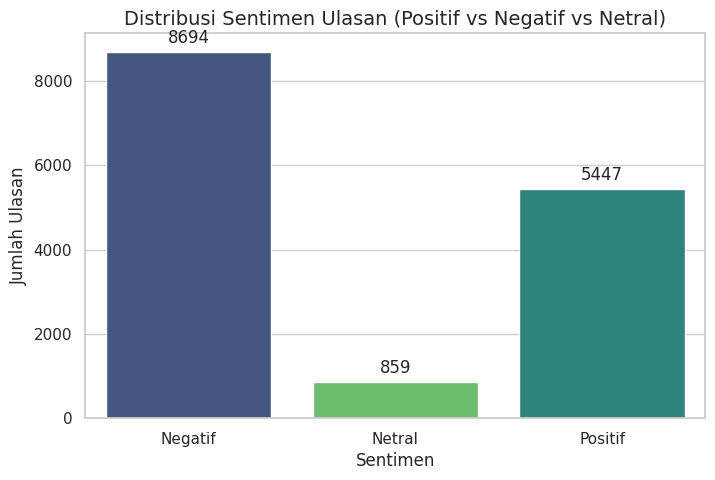

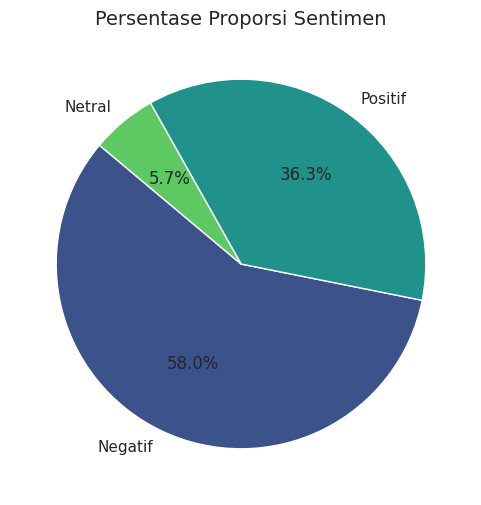

In [12]:
# Set gaya visualisasi
sns.set(style="whitegrid")

# Tambahkan kolom sentimen berdasarkan rating
def classify_sentiment(rating):
    if rating >= 4:
        return 'Positif'
    elif rating == 3:
        return 'Netral'
    else:
        return 'Negatif'

df_reviews['sentiment'] = df_reviews['rating'].apply(classify_sentiment)

# 1. Visualisasi Distribusi Sentimen (Bar Chart)
plt.figure(figsize=(8, 5))
# Addressing FutureWarning: Passing `palette` without assigning `hue` is deprecated.
# Assign 'sentiment' to `hue` and set `legend=False` for the same effect.
ax = sns.countplot(x='sentiment', data=df_reviews, hue='sentiment', palette='viridis', order=['Negatif', 'Netral', 'Positif'], legend=False)

# Menambahkan label angka di atas batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribusi Sentimen Ulasan (Positif vs Negatif vs Netral)', fontsize=14)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

# 2. Visualisasi Persentase (Pie Chart)
plt.figure(figsize=(6, 6))
sentiment_counts = df_reviews['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', 3))
plt.title('Persentase Proporsi Sentimen', fontsize=14)
plt.show()

Generating Word Cloud for Positive Reviews...


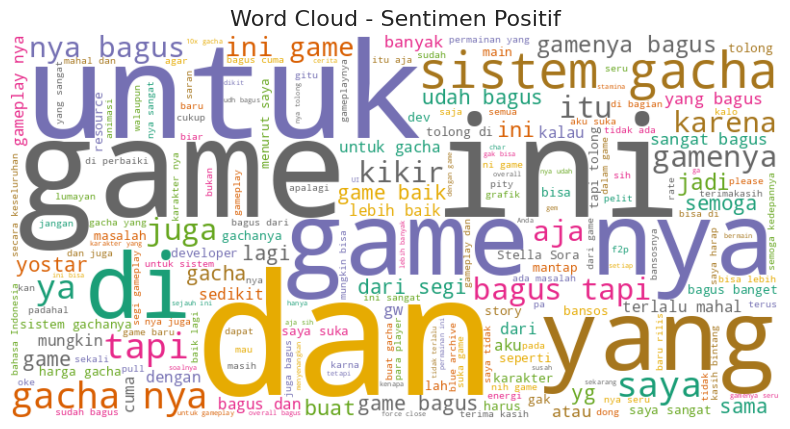

Generating Word Cloud for Negative Reviews...


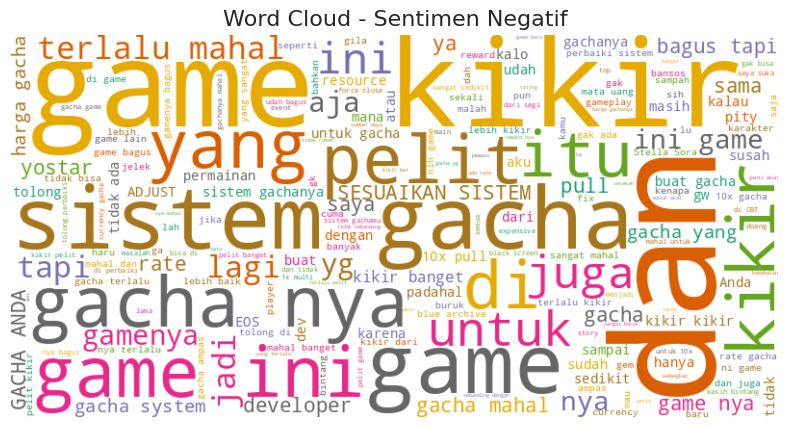

In [13]:
# Fungsi untuk membuat Word Cloud
def generate_wordcloud(text_data, title):
    all_text = ' '.join(text_data.astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Word Cloud untuk Sentimen Positif
print("Generating Word Cloud for Positive Reviews...")
df_positif = df_reviews[df_reviews['sentiment'] == 'Positif']
generate_wordcloud(df_positif['clean_text'], 'Word Cloud - Sentimen Positif')

# Word Cloud untuk Sentimen Negatif
print("Generating Word Cloud for Negative Reviews...")
df_negatif = df_reviews[df_reviews['sentiment'] == 'Negatif']
generate_wordcloud(df_negatif['clean_text'], 'Word Cloud - Sentimen Negatif')

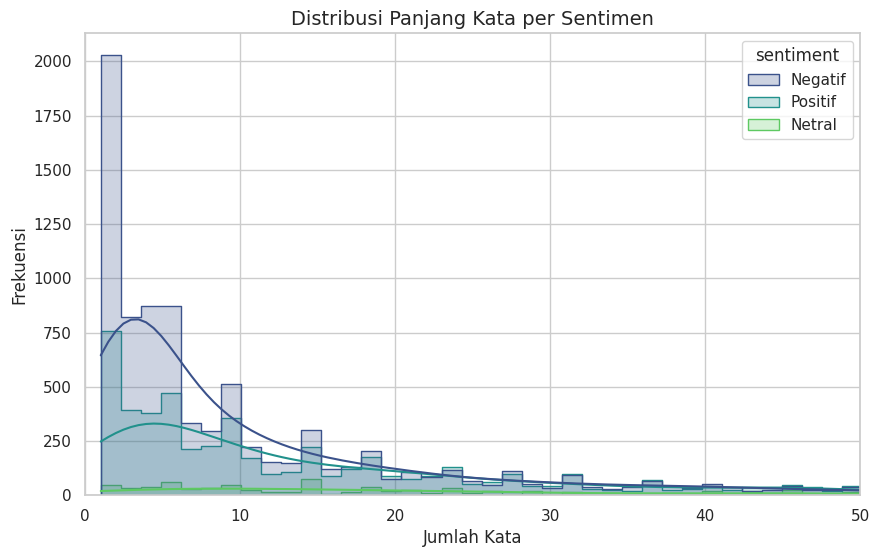

In [14]:
# Hitung jumlah kata per ulasan
df_reviews['word_count'] = df_reviews['clean_text'].apply(lambda x: len(str(x).split()))

# Plot Histogram Distribusi Jumlah Kata
plt.figure(figsize=(10, 6))
sns.histplot(data=df_reviews, x='word_count', hue='sentiment', kde=True, element="step", palette='viridis')
plt.title('Distribusi Panjang Kata per Sentimen', fontsize=14)
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.xlim(0, 50) # Membatasi tampilan x-axis agar tidak terlalu panjang (bisa disesuaikan)
plt.show()